In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

- [x] Предобработка данных
- [x] Анализ данных о регистрациях и займах
- [x] Сколько времени проходит с момента начала регистрации до оформления первого займа
- [x] Срок займа: план-факт + динамика
- [x] Категоризация займов по реальному сроку пользования деньгами
- [x] Исследование суммы займов
- [x] Когортный анализ:
    - [x] User Retention
    - [x] Ср.кол-во займов нарастающим итогом
    - [x] Ср.сумма займа нарастающим итогом
    - [x] ARPU
    - [x] Ретеншен капитала
    - [x] NPL

## Чтение данных и объединение таблиц с данными о регистрациях

In [2]:
# читаем данные
regs1 = pd.read_excel('regs1.xlsx')
regs2 = pd.read_excel('regs2.xlsx')
loans = pd.read_excel('loans.xlsx')

In [3]:
# т.к данные с регистрациями предоставлены в 2ух файлах нам необходимо объеденить их в 1
regs = regs1.append(regs2, ignore_index=True)

## Предобработка данных

### Регистрации

In [4]:
# посмотрим на общую информацию
regs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481285 entries, 0 to 1481284
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   cid              1481285 non-null  int64         
 1   uid              1481285 non-null  object        
 2   ts               1481285 non-null  datetime64[ns]
 3   is_reg_complete  1481285 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 45.2+ MB


In [5]:
# изучим срез данных
regs.sample(5)

,cid,uid,ts,is_reg_complete
1378352,4209858,E05FFC8B-9BA5-4D81-886D-367EEE88E3B2,2020-02-07 12:29:10.580,1
716161,3559791,D50F89AC-9C0F-40F3-815C-28BDF3AAA808,2019-05-15 18:05:01.810,1
251039,2931424,7BB8ED7E-7A70-4607-9E20-4780DEA490F9,2019-01-22 09:09:28.980,0
1445511,4579281,03411856-2C92-4ACC-8692-957A15DB8189,2020-09-26 20:05:12.639,0
684462,3875248,668D51C2-951C-4B2E-BB06-C4EA8E6DF68A,2019-08-27 20:17:07.581,1


<b>cid</b> - id клиента<br>
<b>uid</b> - id юзера<br>
<b>ts</b> - время начала регистрации<br>
<b>is_reg_complete</b> - отметка о завершени регистрации<br>

In [6]:
# uid нам не потребуется в анализе, поэтому просто избавимся от лишней информации
regs.drop(columns=['uid'], inplace=True)

# также приведем к нужному формату данные в ts
regs['ts'] = regs['ts'].astype('datetime64[D]')

# переименуем также один столбец
regs.rename(columns={'ts': 'reg_ts'}, inplace=True)

# проверяем
regs.sample(5)

,cid,reg_ts,is_reg_complete
212885,3218652,2019-03-22,1
1181772,4538645,2020-09-02,1
288195,3225233,2019-03-24,0
719661,3652777,2019-06-29,0
540270,3244860,2019-03-26,0


In [7]:
# проверим таблицу на наличие пропусков и дубликатов
display(regs.isna().sum())
display(regs.duplicated().sum())

cid                0
reg_ts             0
is_reg_complete    0
dtype: int64

0

<div class="alert alert-block alert-success">
<b>Вывод:</b> пропусков и дублей нет, двигаемся дальше
</div>

### Займы

In [8]:
# посмотрим на общую информацию
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397272 entries, 0 to 397271
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   cid       397272 non-null  int64         
 1   uid       397272 non-null  object        
 2   start_ts  381801 non-null  datetime64[ns]
 3   value     397272 non-null  float64       
 4   term      397272 non-null  int64         
 5   status    397272 non-null  object        
 6   end_ts    277092 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 21.2+ MB


In [9]:
# изучим срез данных
loans.sample(5)

,cid,uid,start_ts,value,term,status,end_ts
255937,4000134,EA366F5E-D6FE-4C1C-8069-4ACB9E25BBEE,2020-03-14,3000.0,30,Погашен,2020-03-16 23:59:59.999
218903,4046347,786373D9-06A7-4484-980F-EA51CCC20602,2020-01-19,4300.0,10,Погашен,2020-01-19 23:59:59.999
325581,4365137,C0033684-B81F-4FEE-9778-D1D08E012C00,2020-07-19,5000.0,22,Погашен,2020-08-11 23:59:59.999
303816,4240008,51214CB0-E116-4BB6-A5E9-F6EB8F1EAE15,2020-06-12,4500.0,35,Погашен,2020-07-10 23:59:59.999
90326,3246418,C66918BA-4612-408E-8A03-FD4303942B77,2019-06-07,2000.0,20,Погашен,2019-06-13 23:59:59.999


<b>cid</b> - id клиента<br>
<b>uid</b> - id юзера<br>
<b>start_ts</b> - время получения займа<br>
<b>value</b> - сумма<br>
<b>term</b> - срок<br>
<b>status</b> - статус на текущий момент<br>
<b>end_ts</b> - время возврата займа

In [10]:
# uid нам не потребуется в анализе, поэтому просто избавимся от лишней информации
loans.drop(columns=['uid'], inplace=True)

# также приведем к нужному формату данные в столбце end_ts
loans['end_ts'] = loans['end_ts'].astype('datetime64[D]')

# проверяем
loans.sample(5)

,cid,start_ts,value,term,status,end_ts
86268,3093876,2019-05-28,12000.0,18,Погашен,2019-06-08
309975,4370048,2020-06-22,7000.0,40,Просрочен,NaT
250705,4117932,2020-03-07,16000.0,56,Погашен,2020-03-12
234277,3985226,2020-02-11,6500.0,15,Погашен,2020-03-13
382706,4582207,2020-09-29,5000.0,15,Погашен,2020-09-29


In [11]:
# проверим таблицу на наличие пропусков и дубликатов
display(loans.isna().sum())
display(loans.duplicated().sum())

cid              0
start_ts     15471
value            0
term             0
status           0
end_ts      120180
dtype: int64

1743

<div class="alert alert-block alert-success">
<b>Вывод:</b> есть пропуски и дубликаты, обработаем их
</div>

In [12]:
# посмотим на стутусы займов с пропущенными значениями в столбце 'start_ts'
loans[loans['start_ts'].isna()]['status'].value_counts()

Отменён           15447
Не подтверждён       24
Name: status, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b> фактически эти статусы говорят о том, что клиент не получил деньги
</div>

In [13]:
# удалим эти строки
loans.dropna(subset=['start_ts'], inplace=True)

# проверяем
loans.isna().sum()

cid              0
start_ts         0
value            0
term             0
status           0
end_ts      104709
dtype: int64

In [14]:
# Посмотрим статусы займов, у которых отсутствуетм время погашения
loans[loans['end_ts'].isna()]['status'].value_counts()

Просрочен              41423
На цессии              39043
Активен                14337
На реструктуризации     8616
Отменён                 1025
Списан                   265
Name: status, dtype: int64

In [15]:
# посмотрим, остались ли дубликаты
loans.duplicated().sum()

0

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>дубли теперь отсутствуют
        <li>пропуски в end_ts фактически указывают на то, что заем не был закрыт на момент анализа данных
    </ul>
</div>
Теперь переходоим к анализу данных

## Аналитика данных

### 1. Анализ данных о регистрациях и займах. Динамика по времени, конверсия + графики

Нам нужна таблица, в которой будут данные в динамике по месяцам:
- Общее кол-во регистраций
- Кол-во успешных (завершенных) регистраций
- Общее кол-во займов
- Кол-во новых займов
- Кол-во повторных займов

#### 1.1 Групиировка данных о регистарциях

In [16]:
# добавим в таблицу regs столбцы: date, week, month - день, неделя и месяц регистрации
regs['reg_date'] = regs['reg_ts'].astype('datetime64[D]')
regs['reg_week'] = regs['reg_ts'].dt.to_period('W').apply(lambda r: r.start_time)
regs['reg_month'] = regs['reg_ts'].astype('datetime64[M]')

# проверяем
regs.head()

,cid,reg_ts,is_reg_complete,reg_date,reg_week,reg_month
0,3137743,2019-03-07,1,2019-03-07,2019-03-04,2019-03-01
1,3137786,2019-03-07,1,2019-03-07,2019-03-04,2019-03-01
2,3138236,2019-03-07,1,2019-03-07,2019-03-04,2019-03-01
3,3137950,2019-03-07,1,2019-03-07,2019-03-04,2019-03-01
4,3138043,2019-03-07,1,2019-03-07,2019-03-04,2019-03-01


In [17]:
# сгруппируем данные по месяцам, посчитаем общее кол-во регистраци и кол-во успешных регистраций
regs_by_month = regs.groupby(by='reg_month').agg({'cid': 'nunique', 'is_reg_complete': 'sum'})
regs_by_month.columns = ['total_regs', 'success_regs']

# смотрим
regs_by_month

,total_regs,success_regs
reg_month,,
2019-01-01,129245,83496
2019-02-01,109871,67622
2019-03-01,141537,86071
2019-04-01,158074,95000
2019-05-01,73849,48334
2019-06-01,57813,38789
2019-07-01,95982,61914
2019-08-01,85034,53188
2019-09-01,18303,12616


#### 1.2 Групиировка данных о займах

In [18]:
# у нас уже есть сгруппированные по месяцам данные о регистрациях, теперь тоже самое нужно сделать с займами
# но для начала - добавить в таблицу loans столбцы: date, week, month - день, неделя и месяц регистрации

loans['loan_date'] = loans['start_ts'].dt.date
loans['loan_week'] = loans['start_ts'].dt.to_period('W').apply(lambda r: r.start_time)
loans['loan_month'] = loans['start_ts'].astype('datetime64[M]')

# проверяем
loans.head()

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month
0,2825209,2019-01-01,9900.0,30,Погашен,2019-01-10,2019-01-01,2018-12-31,2019-01-01
1,2825218,2019-01-01,17000.0,28,Погашен,2019-01-10,2019-01-01,2018-12-31,2019-01-01
7,2825331,2019-01-01,9800.0,19,На цессии,NaT,2019-01-01,2018-12-31,2019-01-01
8,2825254,2019-01-01,5000.0,20,На цессии,NaT,2019-01-01,2018-12-31,2019-01-01
9,2825359,2019-01-01,7000.0,30,Погашен,2019-03-02,2019-01-01,2018-12-31,2019-01-01


In [19]:
# для начала для каждого юзера найдем месяц первого займа
new_loans_by_month = loans.sort_values(by=['cid', 'start_ts']).groupby(by='cid').agg({'loan_month': 'first'}).reset_index()

# теперь сгруппируем данные по месяцам и подсчитаем кол-во уникальны займов
new_loans_by_month = new_loans_by_month.groupby(by='loan_month').agg({'cid': 'count'})
new_loans_by_month.columns = ['new_loans']

# проверяем
new_loans_by_month

,new_loans
loan_month,
2019-01-01,7874
2019-02-01,8775
2019-03-01,12097
2019-04-01,13205
2019-05-01,7160
2019-06-01,4920
2019-07-01,9910
2019-08-01,8474
2019-09-01,4067


In [20]:
# теперь посчитаем общее кол-во займов по месяцам
total_loans_by_month = loans.groupby(by='loan_month').agg({'cid': 'count'})
total_loans_by_month.columns = ['total_loans']

# проверяем
total_loans_by_month

,total_loans
loan_month,
2019-01-01,9051
2019-02-01,13253
2019-03-01,20531
2019-04-01,23563
2019-05-01,16104
2019-06-01,12850
2019-07-01,18986
2019-08-01,19323
2019-09-01,12914


In [21]:
# объеденим таблицы total_loans_by_month и new_loans_by_month
loans_by_month = pd.merge(total_loans_by_month, new_loans_by_month, on='loan_month')

# рассчитаем кол-во повторных займов
loans_by_month['repeated_loans'] = loans_by_month['total_loans'] - loans_by_month['new_loans']

# проверяем
loans_by_month

,total_loans,new_loans,repeated_loans
loan_month,,,
2019-01-01,9051,7874,1177
2019-02-01,13253,8775,4478
2019-03-01,20531,12097,8434
2019-04-01,23563,13205,10358
2019-05-01,16104,7160,8944
2019-06-01,12850,4920,7930
2019-07-01,18986,9910,9076
2019-08-01,19323,8474,10849
2019-09-01,12914,4067,8847


#### 1.3 Объеденение данных в одну таблицу

In [22]:
total_grouped_data = pd.merge(regs_by_month, loans_by_month, left_index=True, right_index=True)

total_grouped_data

,total_regs,success_regs,total_loans,new_loans,repeated_loans
2019-01-01,129245,83496,9051,7874,1177
2019-02-01,109871,67622,13253,8775,4478
2019-03-01,141537,86071,20531,12097,8434
2019-04-01,158074,95000,23563,13205,10358
2019-05-01,73849,48334,16104,7160,8944
2019-06-01,57813,38789,12850,4920,7930
2019-07-01,95982,61914,18986,9910,9076
2019-08-01,85034,53188,19323,8474,10849
2019-09-01,18303,12616,12914,4067,8847
2019-10-01,44275,32160,14548,6012,8536


#### 1.4 Графики

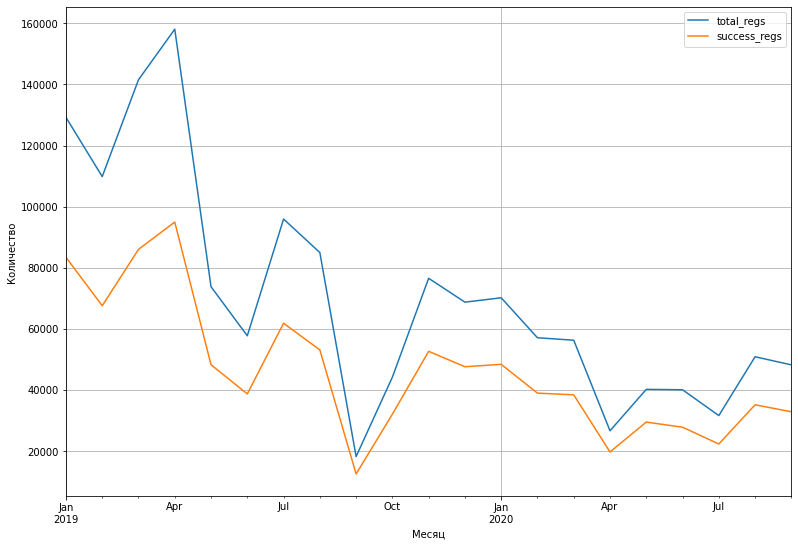

In [23]:
# построим график динамики регистраций по месяцам
total_grouped_data[['total_regs', 'success_regs']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество');

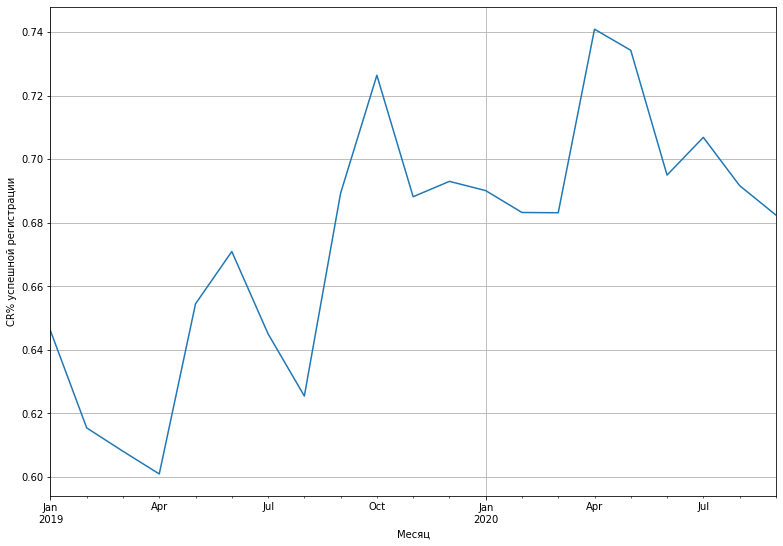

In [24]:
# а также ихучим конверсию из всех регистраций в успешные
(total_grouped_data['success_regs'] / total_grouped_data['total_regs']).plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('CR% успешной регистрации');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>количетсво регистраций (всех/успешных) стабильно сокращалось с апрелья 2019 года
        <li>при этом конверсия в успешную регистрацию за этот же период показала стабильный рост и достигла порядка 70%
    </ul>
</div>

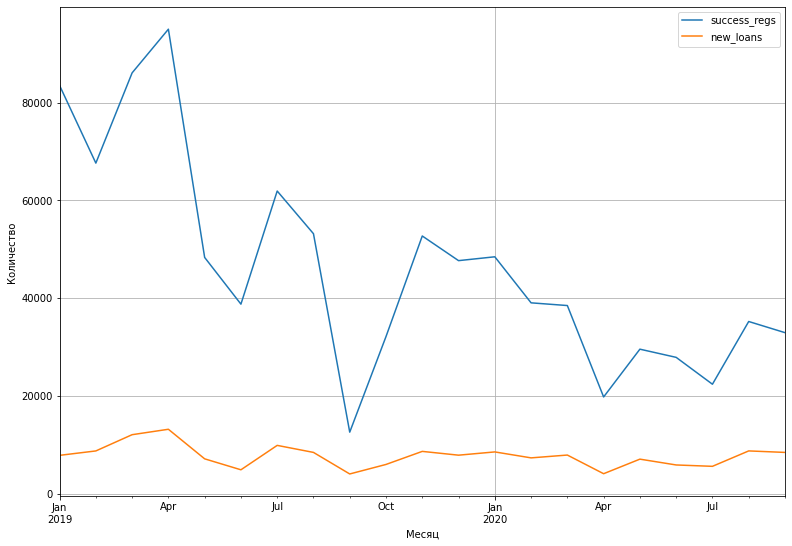

In [25]:
# теперь на одном графике сравним динамику успешных регистраций и новых займов
total_grouped_data[['success_regs', 'new_loans']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество');

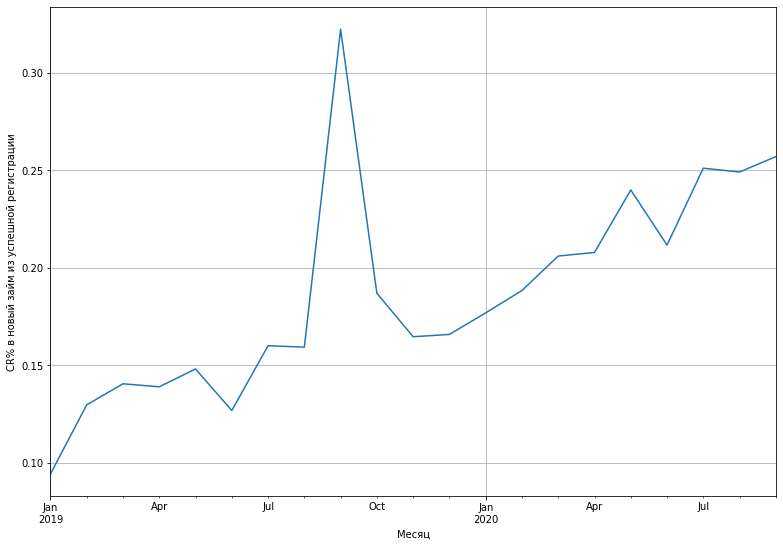

In [26]:
# а также посмотрим на конверсию в динамике
(total_grouped_data['new_loans'] / total_grouped_data['success_regs']).plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('CR% в новый займ из успешной регистрации');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>при стабильном сокращении успешных регистраций кол-во новых займов осталось практически на том же уровне
        <li>можно констатировать, что произошло это в первую очередь за счет роста конверсии в новый заем с 15% до 25%
        <li>однако это общие данные, которые состаят из различных источников трафика в тч высококонверсионной органики (в тч брендовой). Судя по данным из affise CPA канал в августе имел CR = 17%
    </ul>
</div>

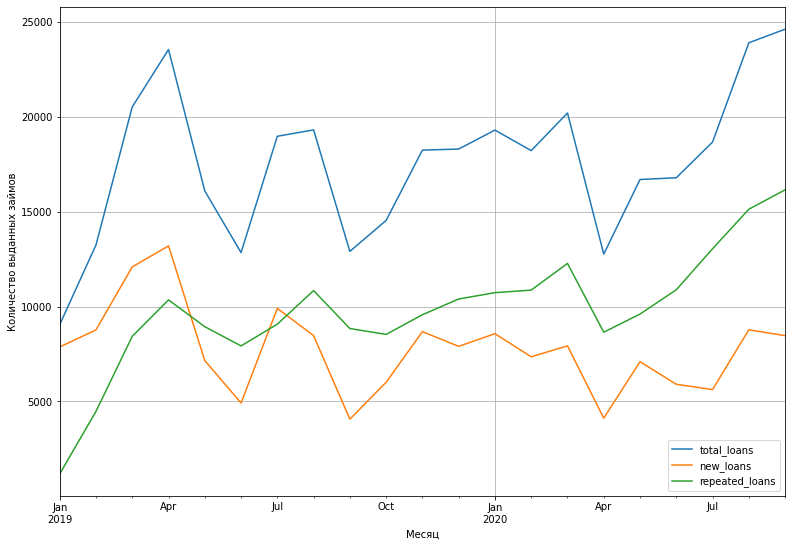

In [27]:
# посмотрим на долю потворных займов в динамике
total_grouped_data[['total_loans', 'new_loans', 'repeated_loans']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество выданных займов');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>ближе к концу анализируемого периода наблюдается рост общего количества выданных займов
        <li>происходит это за счет роста повторных выдач. Это хороший для нас показатель
        <li>доля вопвторных займов колеблется в диапазоне 60%-70%
    </ul>
</div>

### 2. Сколько времени проходит с момента начала регистрации до оформления первого займа

In [28]:
# для начала из таблицы loans нам нужно получить для каждого юзера данные о его первом займе
first_loan_ts = loans.sort_values(by=['cid', 'start_ts']).groupby(by='cid').agg({'start_ts': 'first'}).reset_index()
first_loan_ts.columns=['cid', 'start_loan']

# проверяем
first_loan_ts.head()

,cid,start_loan
0,2825209,2019-01-01
1,2825218,2019-01-01
2,2825225,2019-03-30
3,2825230,2020-09-12
4,2825232,2019-07-27


In [29]:
# теперь добавим эти данные в таблицу с регистрациями
time_to_loan = pd.merge(regs, first_loan_ts, how='left', on='cid')

# посмотрим на случайные 20 записей из получившейся таблицы
time_to_loan.sample(20)

,cid,reg_ts,is_reg_complete,reg_date,reg_week,reg_month,start_loan
13650,3089665,2019-02-24,1,2019-02-24,2019-02-18,2019-02-01,NaT
1169067,4163282,2020-01-18,1,2020-01-18,2020-01-13,2020-01-01,NaT
90486,3026118,2019-02-09,1,2019-02-09,2019-02-04,2019-02-01,NaT
753666,3436154,2019-04-22,1,2019-04-22,2019-04-22,2019-04-01,NaT
303757,3352878,2019-04-08,0,2019-04-08,2019-04-08,2019-04-01,NaT
1303385,4498301,2020-08-12,0,2020-08-12,2020-08-10,2020-08-01,NaT
1051932,4417416,2020-06-08,1,2020-06-08,2020-06-08,2020-06-01,NaT
1380667,4377714,2020-05-16,0,2020-05-16,2020-05-11,2020-05-01,NaT
908512,3056213,2019-02-16,1,2019-02-16,2019-02-11,2019-02-01,NaT
172902,3201462,2019-03-20,1,2019-03-20,2019-03-18,2019-03-01,NaT


<div class="alert alert-block alert-info">
<b>Важно:</b> во многих строках столбца start_loan появились значения NaT. Это говорит о том, что клиент начал регистрацию, но в итоге ни одного займа не получил. Избавимся от этих строк</div>

In [30]:
# удаляем лишние строки
time_to_loan.dropna(subset=['start_loan'], inplace=True)

In [31]:
# добавим в таблицу новый столбец с кол-во дней с начала регистрации до первого займа
time_to_loan['days_to_loan'] = (time_to_loan['start_loan'] - time_to_loan['reg_ts']).dt.days

time_to_loan.sample(10)

,cid,reg_ts,is_reg_complete,reg_date,reg_week,reg_month,start_loan,days_to_loan
415129,3864598,2019-08-24,1,2019-08-24,2019-08-19,2019-08-01,2019-11-05,73
406554,2865663,2019-01-09,1,2019-01-09,2019-01-07,2019-01-01,2019-02-09,31
793768,3476631,2019-04-28,1,2019-04-28,2019-04-22,2019-04-01,2019-04-28,0
816087,2954050,2019-01-26,1,2019-01-26,2019-01-21,2019-01-01,2020-01-07,346
1307205,4327675,2020-04-04,1,2020-04-04,2020-03-30,2020-04-01,2020-06-17,74
1059731,4391496,2020-05-24,1,2020-05-24,2020-05-18,2020-05-01,2020-05-24,0
1064714,4427541,2020-06-14,1,2020-06-14,2020-06-08,2020-06-01,2020-06-14,0
1198641,4413196,2020-06-05,1,2020-06-05,2020-06-01,2020-06-01,2020-06-05,0
560184,3401209,2019-04-16,1,2019-04-16,2019-04-15,2019-04-01,2019-04-27,11
863770,4026301,2019-11-22,1,2019-11-22,2019-11-18,2019-11-01,2019-11-25,3


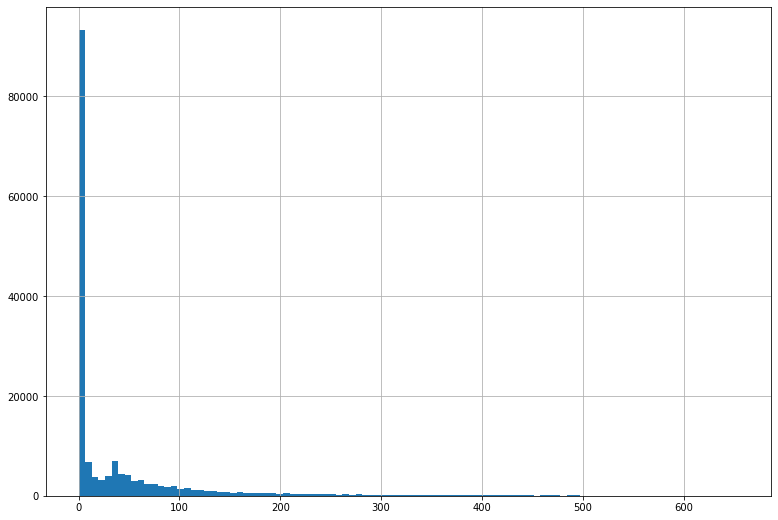

In [32]:
# построим гистограмму
time_to_loan['days_to_loan'].hist(figsize=(13, 9), bins=100);

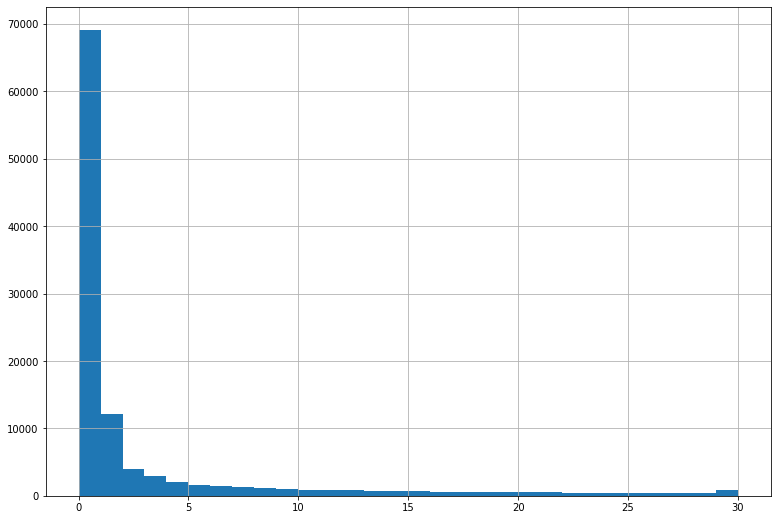

In [33]:
# львиная доля значений лежит в диапазоне от 0 до 30 дней, ограничим гистограмму этими значениями
time_to_loan['days_to_loan'].hist(figsize=(13, 9), bins=30, range=(0, 30));

In [34]:
# посмотрим на ТОП10 значений
time_to_loan['days_to_loan'].value_counts().head(10)

0     69106
1     12103
2      4033
3      2921
4      2042
5      1615
6      1445
7      1296
32     1198
8      1159
Name: days_to_loan, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>львиная доля клиентов получают свой первый заем в день регистрации
        <li>кол-во выдач на следующий день относительно большое, но это в т.ч. может быть связано с займами, которые оформляются в вечернее время и выдаются уже на следующий день
        <li>есть небольшой скачок на 32 день. Скорее всего это связано с разблокировкой спустя 30 дней
        <li>чем дальше от времени регистрации тем меньше шанс, что клиент оформит свой первый заем
        <li>в качестве рекомендации - нужно стараться максимально быстро конвертировать регистрацию в первый заем
    </ul>
</div>

### 3. Исследвание срока займа (план, факт) + динамика по месяцам

#### 3.1 Запрашиваемые и фактические значения займов

In [35]:
# рассчитаем фактический срок пользования деньгами
loans['real_term'] = (loans['end_ts'] - loans['start_ts']).dt.days

# удалим пустые значения т.к. нам нужны только те займы, которые уже погашены и сохраним данные в отдельный датафрейм
real_term = loans.query('real_term.notna()')
real_term['real_term'] = real_term['real_term'].astype('int')

# проверим на выборке
real_term.sample(10)

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month,real_term
184729,3756272,2019-11-25,2000.0,10,Погашен,2019-11-28,2019-11-25,2019-11-25,2019-11-01,3
371959,3490097,2020-09-17,11000.0,40,Погашен,2020-10-15,2020-09-17,2020-09-14,2020-09-01,28
216800,3840522,2020-01-15,2220.0,10,Погашен,2020-01-25,2020-01-15,2020-01-13,2020-01-01,10
185586,4035997,2019-11-26,10000.0,23,Погашен,2019-12-19,2019-11-26,2019-11-25,2019-11-01,23
362990,3001278,2020-09-05,6000.0,56,Погашен,2020-09-18,2020-09-05,2020-08-31,2020-09-01,13
361265,4049891,2020-09-03,4900.0,34,Погашен,2020-10-07,2020-09-03,2020-08-31,2020-09-01,34
378799,4331498,2020-09-25,8000.0,30,Погашен,2020-09-27,2020-09-25,2020-09-21,2020-09-01,2
167642,3916229,2019-10-30,4000.0,11,Погашен,2020-01-13,2019-10-30,2019-10-28,2019-10-01,75
18073,3068072,2019-02-18,15000.0,30,Погашен,2019-06-03,2019-02-18,2019-02-18,2019-02-01,105
368638,2863351,2020-09-13,3000.0,20,Погашен,2020-10-16,2020-09-13,2020-09-07,2020-09-01,33


In [36]:
# сравним сумму дней из запросов пользователей с суммой фактических дней пользования кредитом
print(f'Всего займов было оформлено на {real_term["term"].sum():,} дня(ей)')
print(f'Фактически с учетом досрочных погашений и просрочек деньгами пользовались {real_term["real_term"].sum():,} дня(ей)')

Всего займов было оформлено на 8,188,355 дня(ей)
Фактически с учетом досрочных погашений и просрочек деньгами пользовались 9,051,054 дня(ей)


<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> Суммарный фактичесий срок пользования деньгами на 10,5% (или 862,699 дней) больше, чем все суммарные запрошенные значения. Это даже с учетом займов, которые погашаются досрочно (спойлер: их достаточно много)
    </ul>
</div>

count    277092.000000
mean         29.551034
std          22.314454
min           7.000000
25%          16.000000
50%          30.000000
75%          33.000000
max         168.000000
Name: term, dtype: float64

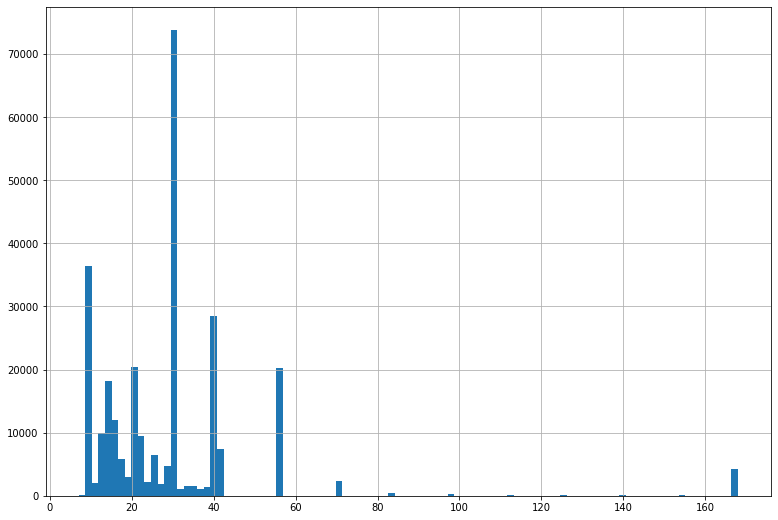

In [37]:
# распределение запрашиваемых сроков займов
display(real_term['term'].describe())
real_term['term'].hist(bins=100, figsize=(13, 9));

#### 3.2 Распределение показателей, среднее значение, медиана, мода

count    277092.000000
mean         32.664436
std          39.842293
min           0.000000
25%           8.000000
50%          20.000000
75%          42.000000
max         627.000000
Name: real_term, dtype: float64

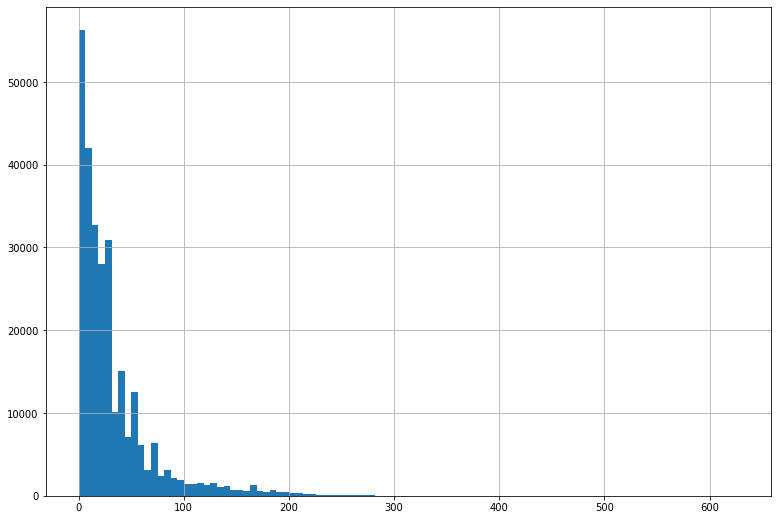

In [38]:
# распределение фактических сроков пользования займом
display(real_term['real_term'].describe())
real_term['real_term'].hist(bins=100, figsize=(13, 9));

In [39]:
# ТОП5 запрашиваемых сроков
real_term['term'].value_counts().head()

30    70700
10    36454
40    28544
56    20225
20    16165
Name: term, dtype: int64

In [40]:
# ТОП5 фактических сроков
real_term['real_term'].value_counts().head()

1     9767
10    9651
0     9439
30    9265
56    8488
Name: real_term, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>графики распределения отличаются очень сильно. Это говорит о том, что то, как люди планируют возвращать деньги и то, как они их возвращают - это разные значения
        <li>также на распределение оказывает влияение то, что запрашиваемый срок займа строго ограничен
        <li>среднее значение фактического пользования займом = 32.66 дня, средний запрашиваемый срок = 29.55 дня
        <li>медианное значение больше уже у запрашиваемых показателй - 30 дней против 20 дней. Т.е. 50% займов закрываются в срок до 20 дней
        <li>в ТОП5 значений фактического пользования займами есть 2 не очень хороших значения - это 0 день (погашение в день получения займа) и 1 (погашение на следующий день)
        <li>25% займов погашаются до 8 дней, 50% до 20 дней, 75% до 42 дней. Над этими показателями стоило бы поработать
    </ul>
</div>

#### 3.3 Динамка планового и фактического срока пользования деньгами

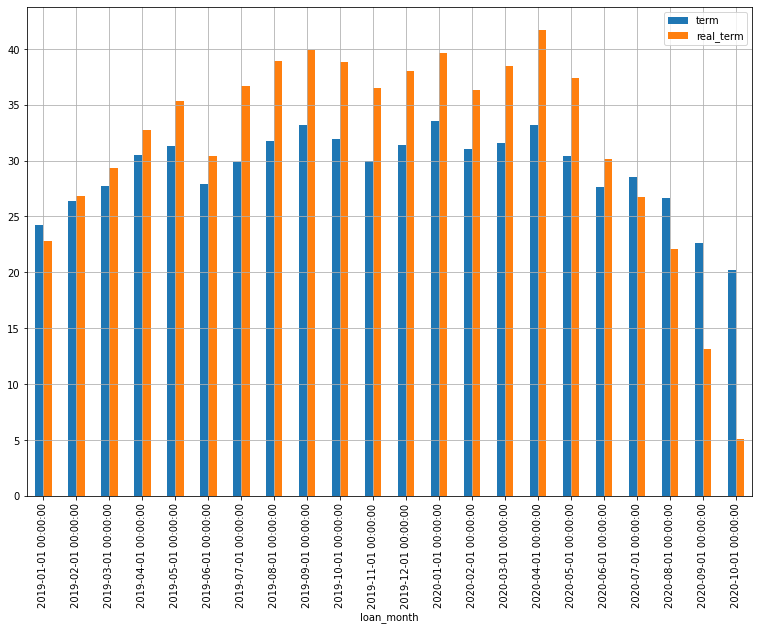

In [41]:
real_term.groupby('loan_month').agg({'term': 'mean', 'real_term': 'mean'}).plot(kind='bar', figsize=(13, 9), grid=True);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>весь 2019 год средний срок пользовния деньгами показывал положительную динамику
        <li>в этот же период мы видим значительно большой рост факт.пользования отностилеьно плана
        <li>начиная с июля график идет вниз, но это скорее всего связано с тем, что часть клиентов из просрочки еще не вернули деньги (но согласно статистике обязательно вернут) либо доля досрочных погашений выросла
        <li>в дальнейшем посомотрим еще на эти показатели в когортах
    </ul>
</div>

### 4. Категоризация займов по реальному сроку пользования деньгами

In [42]:
# созданим функцию категоризации срока закрытия займа
def set_term_category(row):
    if row['real_term'] == row['term']:
        return 'В срок'
    elif row['real_term'] < row['term']:
        return 'Досрочно'
    elif row['real_term'] > row['term']:
        return 'С просрочкой'
    return 'Не закрыт'

In [43]:
# применяем функцию
loans['term_category'] = loans.apply(set_term_category, axis=1)

# проверяем
loans.sample(10)

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month,real_term,term_category
82952,3408462,2019-05-21,10000.0,30,Погашен,2019-06-18,2019-05-21,2019-05-20,2019-05-01,28.0,Досрочно
114380,3644354,2019-07-23,6000.0,30,Погашен,2019-08-23,2019-07-23,2019-07-22,2019-07-01,31.0,С просрочкой
295784,4399693,2020-05-28,18400.0,40,Просрочен,NaT,2020-05-28,2020-05-25,2020-05-01,NaN,Не закрыт
120124,3768853,2019-07-31,8560.0,40,Просрочен,NaT,2019-07-31,2019-07-29,2019-07-01,NaN,Не закрыт
181967,3444410,2019-11-21,4440.0,30,На цессии,NaT,2019-11-21,2019-11-18,2019-11-01,NaN,Не закрыт
388769,4524509,2020-10-07,5000.0,40,Погашен,2020-10-08,2020-10-07,2020-10-05,2020-10-01,1.0,Досрочно
65443,3381400,2019-04-25,3500.0,20,Погашен,2019-05-14,2019-04-25,2019-04-22,2019-04-01,19.0,Досрочно
33547,3046471,2019-03-17,5000.0,30,Погашен,2019-03-28,2019-03-17,2019-03-11,2019-03-01,11.0,Досрочно
149848,3726426,2019-09-21,8000.0,40,На цессии,NaT,2019-09-21,2019-09-16,2019-09-01,NaN,Не закрыт
289209,4258622,2020-05-17,1700.0,14,Погашен,2020-05-19,2020-05-17,2020-05-11,2020-05-01,2.0,Досрочно


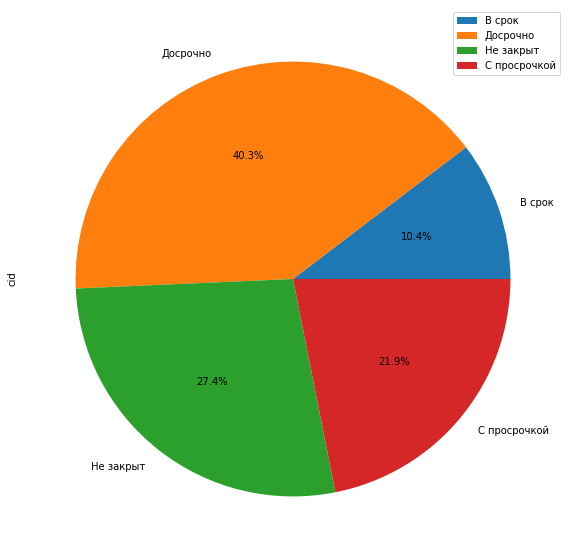

In [44]:
# построим круговую диаграмму для визуализации разделения займов по типам погашения
loans.groupby('term_category').agg({'cid': 'count'}).plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.1f%%');

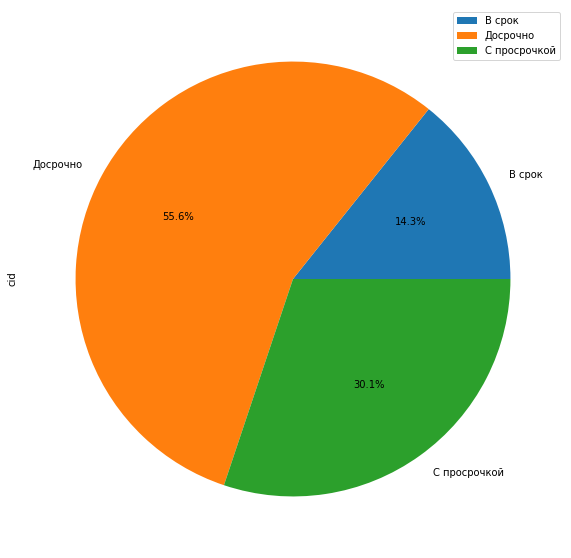

In [45]:
# та же диаграмма, но без статуса "Не закрыт"
loans.query('term_category != "Не закрыт"')\
.groupby('term_category').agg({'cid': 'count'}).plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.1f%%');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>27.4% не закрытых займов - цифра немного преувеличенная т.к. чем ближе анализируемый месяц к текущему - тем больше % невозвратов и наоборот.
        <li>Если анализировать уже закрытые займы - 55.6% досрочно закрытых займов это большая цифра. И это как раз точка роста
    </ul>
</div>

### 4. Исследование суммы займов

#### 4.1 Базовые данные о сумме займов

In [46]:
print(f'Суммарные выдачи за анализируемый период составили {loans["value"].sum():,} рублей')

Суммарные выдачи за анализируемый период составили 3,683,503,741.4 рублей


In [47]:
# посмотрим на среднее, медиану, квартили и другие значения
loans['value'].describe()

count    381801.00000
mean       9647.70585
std        6590.64607
min        1500.00000
25%        4500.00000
50%        8000.00000
75%       13000.00000
max       80500.00000
Name: value, dtype: float64

In [48]:
# TOP10 частотность
loans['value'].value_counts().head(10)

8000.0     28526
10000.0    23204
4000.0     15457
5000.0     13786
12000.0    13612
3000.0     13293
2000.0     11944
6500.0      9925
3500.0      8942
14000.0     8025
Name: value, dtype: int64

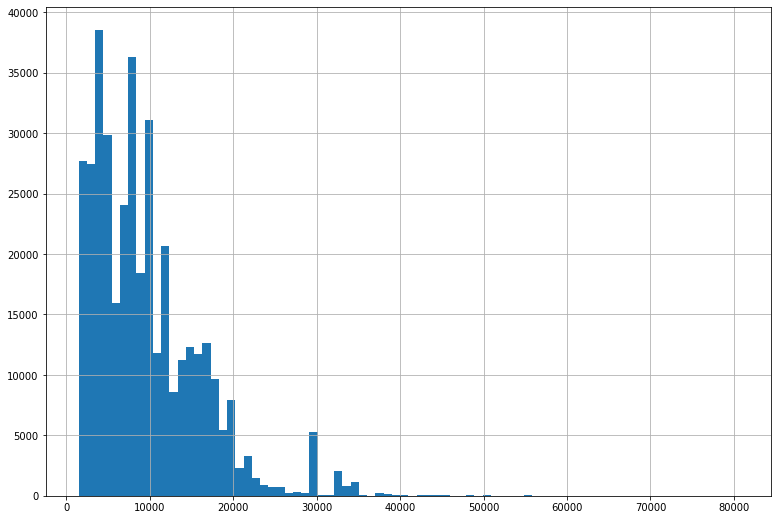

In [49]:
# посмотрим на распределение
loans['value'].hist(figsize=(13, 9), bins=80);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>общая сумма выданных средств за анализируемый период 3 683 503 741 рубля
        <li>средняя выдача - 9648 рублей
        <li>первый-третий квартили: 4500, 8000, 12000. Это значит, что 25% займов оформляются на сумму, меньше 4500р, 50% займов на сумму до 8000 и 75% займов на сумму до 12000 рублей.
        <li>чаще всего берут займ на 8000 рублей (28526 раз)
        <li>в ТОП10 значений по частоте 7 значений меньше 10000 рублей
    </ul>
</div>

#### 4.2 Динамика измениня средней суммы займа

In [50]:
# группируем данные по месяцам, для каждого месяца считаем суммарный объем займов и количество займов
avg_loan_value = loans.groupby('loan_month').agg({'value': 'sum', 'cid': 'count'})

# переименуюем столбцы
avg_loan_value.columns=['total_value', 'total_loans']

# посчитаем средний чек
avg_loan_value['avg_loan_value'] = (avg_loan_value['total_value'] / avg_loan_value['total_loans']).astype('int')

avg_loan_value

,total_value,total_loans,avg_loan_value
loan_month,,,
2019-01-01,73801900.0,9051,8154
2019-02-01,113125700.0,13253,8535
2019-03-01,184448300.0,20531,8983
2019-04-01,225085500.0,23563,9552
2019-05-01,169450693.4,16104,10522
2019-06-01,124287411.0,12850,9672
2019-07-01,187047644.0,18986,9851
2019-08-01,200497845.0,19323,10376
2019-09-01,137818936.0,12914,10672


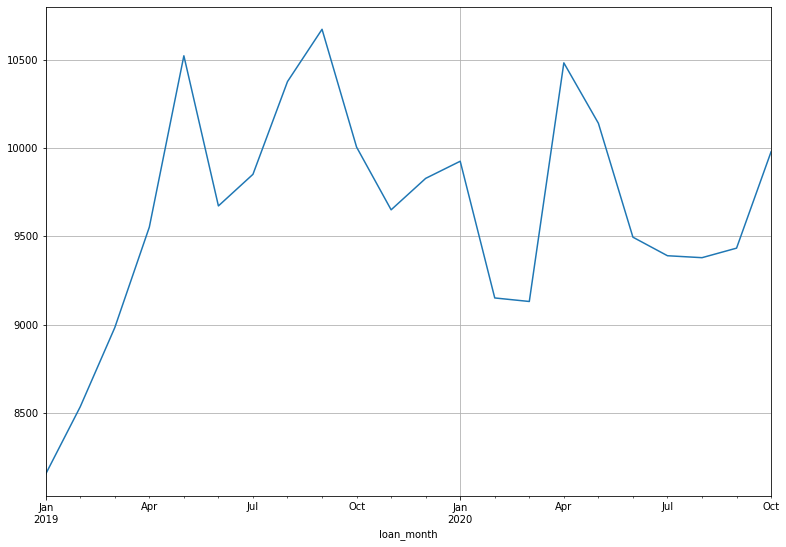

In [51]:
# посмотрим на чек в динамике
avg_loan_value['avg_loan_value'].plot(figsize=(13, 9), grid=True);

In [52]:
print(f'Минимальное занчение {avg_loan_value["avg_loan_value"].min()} рубл.')
print(f'Максимальное занчение {avg_loan_value["avg_loan_value"].max()} руб.')

Минимальное занчение 8154 рубл.
Максимальное занчение 10672 руб.


<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>мин-макс средние значения находятся в диапазоне от 8154 руб до 10672 руб
        <li>не прослеживается какой-либо тренд на рост-падение, есть только периодические колебания на 10-20%
    </ul>
</div>

### 5. Когортный анализ

#### 5.1 Ретеншен

In [53]:
# для начала нам нужно выделить в отдельную таблицу месяц первого займа для каждого пользователя
loan_first_month = loans.sort_values(by=['cid', 'loan_month']).groupby(by='cid').agg({'loan_month': 'first'}).reset_index()

# переименуем столбцы
loan_first_month.columns = ['cid', 'loan_first_month']

# смотрим на результат
loan_first_month

,cid,loan_first_month
0,2825209,2019-01-01
1,2825218,2019-01-01
2,2825225,2019-03-01
3,2825230,2020-09-01
4,2825232,2019-07-01
...,...,...
164967,4587065,2020-10-01
164968,4587072,2020-10-01
164969,4587089,2020-09-01
164970,4587094,2020-09-01


In [54]:
# объеденим таблицы loans vs loan_first_month
loans = pd.merge(loans, loan_first_month, on='cid')

# добавим в таблицу столбец cohort_lifetime, который указывает на срок жизни когорты в месяцах
loans['cohort_lifetime'] =((loans['loan_month'] - loans['loan_first_month']) / np.timedelta64(1,'M'))\
.round().astype('int')

# смотрим на результат
loans.head()

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month,real_term,term_category,loan_first_month,cohort_lifetime
0,2825209,2019-01-01,9900.0,30,Погашен,2019-01-10,2019-01-01,2018-12-31,2019-01-01,9.0,Досрочно,2019-01-01,0
1,2825209,2019-01-14,10000.0,30,Погашен,2019-01-18,2019-01-14,2019-01-14,2019-01-01,4.0,Досрочно,2019-01-01,0
2,2825209,2019-01-25,10000.0,23,Погашен,2019-01-25,2019-01-25,2019-01-21,2019-01-01,0.0,Досрочно,2019-01-01,0
3,2825209,2019-01-30,10000.0,16,Погашен,2019-02-11,2019-01-30,2019-01-28,2019-01-01,12.0,Досрочно,2019-01-01,0
4,2825209,2019-02-24,10000.0,16,Погашен,2019-03-12,2019-02-24,2019-02-18,2019-02-01,16.0,В срок,2019-01-01,1


In [55]:
# создадим новую таблицу retention и сгруппируем в нее данные из таблицы loans
retention = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'nunique'}).reset_index()

# переименуем колонки
retention.columns = ['loan_first_month', 'cohort_lifetime', 'active_users']

# смотрим результат
retention

,loan_first_month,cohort_lifetime,active_users
0,2019-01-01,0,7874
1,2019-01-01,1,2858
2,2019-01-01,2,2094
3,2019-01-01,3,1360
4,2019-01-01,4,666
...,...,...,...
248,2020-08-01,1,2424
249,2020-08-01,2,1560
250,2020-09-01,0,8472
251,2020-09-01,1,1689


In [56]:
# теперь в отдельной таблице сохраним пользователей нулевой когорты
initial_users = retention[retention['cohort_lifetime'] == 0][['loan_first_month', 'active_users']]

# переименуем столбцы
initial_users.columns = ['loan_first_month', 'initial_users']

# смотрим результат
initial_users

,loan_first_month,initial_users
0,2019-01-01,7874
22,2019-02-01,8775
43,2019-03-01,12097
63,2019-04-01,13205
82,2019-05-01,7160
100,2019-06-01,4920
117,2019-07-01,9910
133,2019-08-01,8474
148,2019-09-01,4067
162,2019-10-01,6012


In [57]:
# добавим в таблицу retention столбец initial_users из таблицы initial_users
retention = pd.merge(retention, initial_users, on='loan_first_month')

# рассчитаем retention_rate
retention['retention_rate'] = retention['active_users'] / retention['initial_users']

# смотрим финальную таблицу
retention.head()

,loan_first_month,cohort_lifetime,active_users,initial_users,retention_rate
0,2019-01-01,0,7874,7874,1.000000
1,2019-01-01,1,2858,7874,0.362967
2,2019-01-01,2,2094,7874,0.265939
3,2019-01-01,3,1360,7874,0.172720
4,2019-01-01,4,666,7874,0.084582


In [58]:
# группируем все в сводную таблицу
retention_pivot = retention.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                                        values='retention_rate', aggfunc='sum')

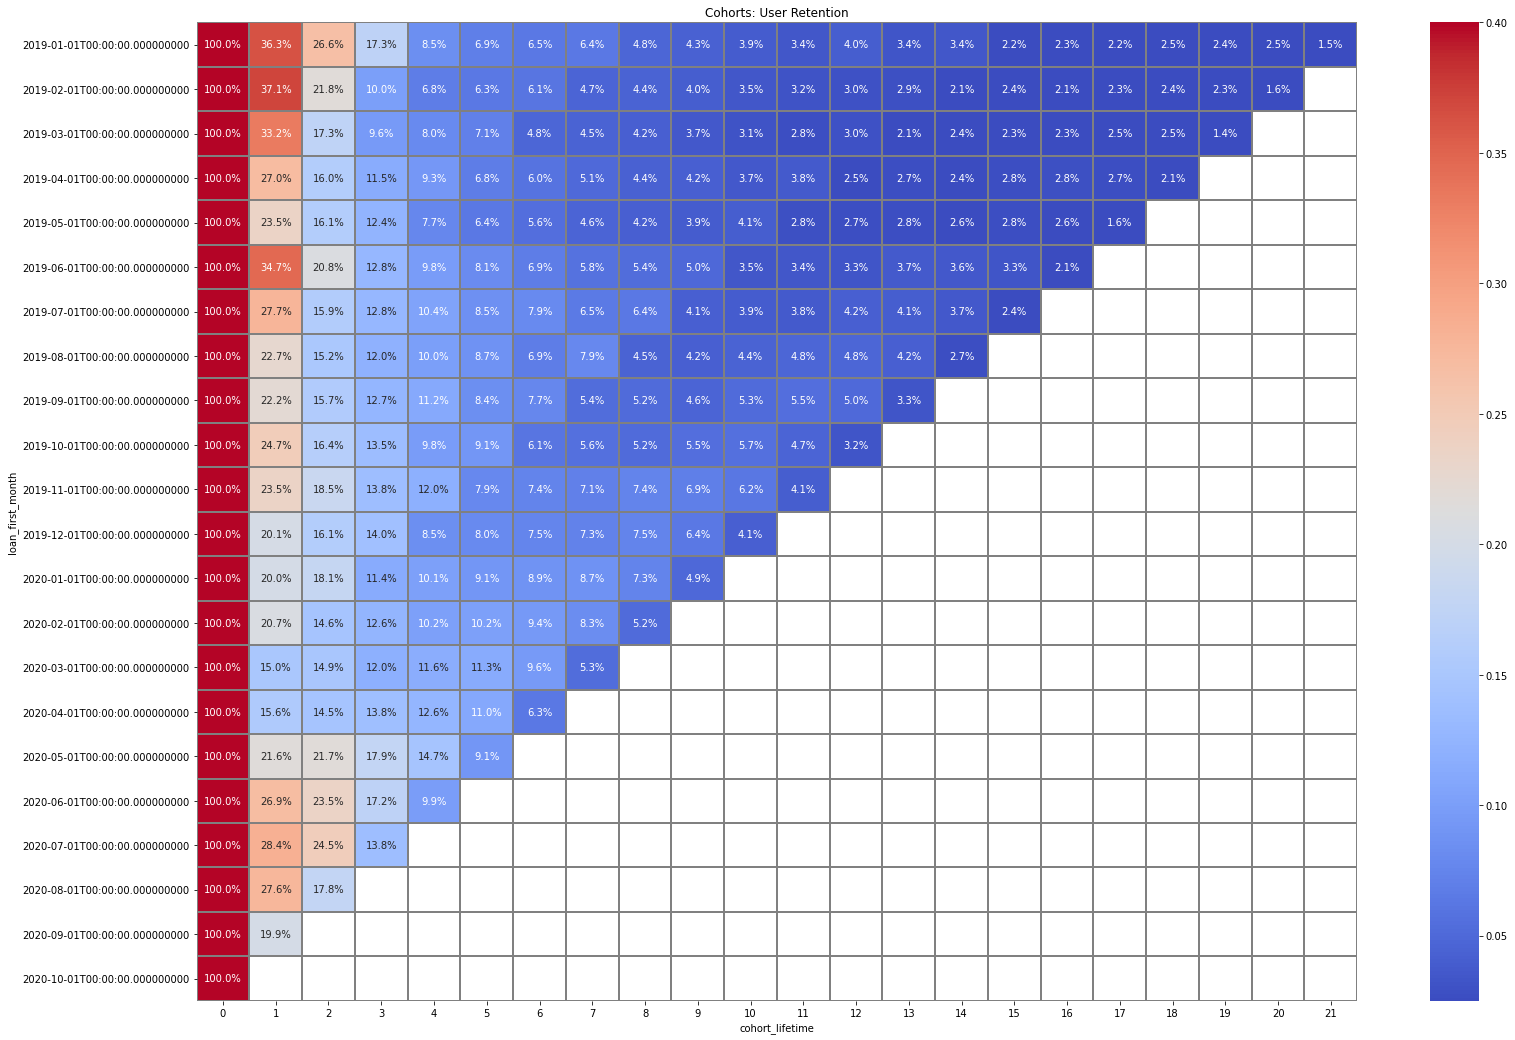

In [59]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmax=0.4, vmin=0.025);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>в начале и середине 2019 года мы видим достаточно хороший ретеншен в месяцах 0-1-2
        <li>затем, примерно в авгуте 2019 показатели стали ухудшаться и ретеншен 1 месяца опустился до 20%, а затем и вовсе до 15%
        <li>однако сейчас снова наблюдается рост, начиная с мая 2020
    </ul>
</div>

#### 5.2 Среднее кол-во займов

In [60]:
avg_loan_amount = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'count'}).reset_index()
avg_loan_amount.rename(columns={'cid': 'cumsum_loans'}, inplace=True)
avg_loan_amount = pd.merge(avg_loan_amount, initial_users, on='loan_first_month')
avg_loan_amount['avg_loans'] = (avg_loan_amount['cumsum_loans'] / avg_loan_amount['initial_users']).round(2)

avg_loan_amount.head()

,loan_first_month,cohort_lifetime,cumsum_loans,initial_users,avg_loans
0,2019-01-01,0,9051,7874,1.15
1,2019-01-01,1,3447,7874,0.44
2,2019-01-01,2,2628,7874,0.33
3,2019-01-01,3,1623,7874,0.21
4,2019-01-01,4,748,7874,0.09


In [61]:
avg_loan_pivot = avg_loan_amount.pivot_table(index='loan_first_month', columns='cohort_lifetime', values='avg_loans', aggfunc='mean').cumsum(axis=1)

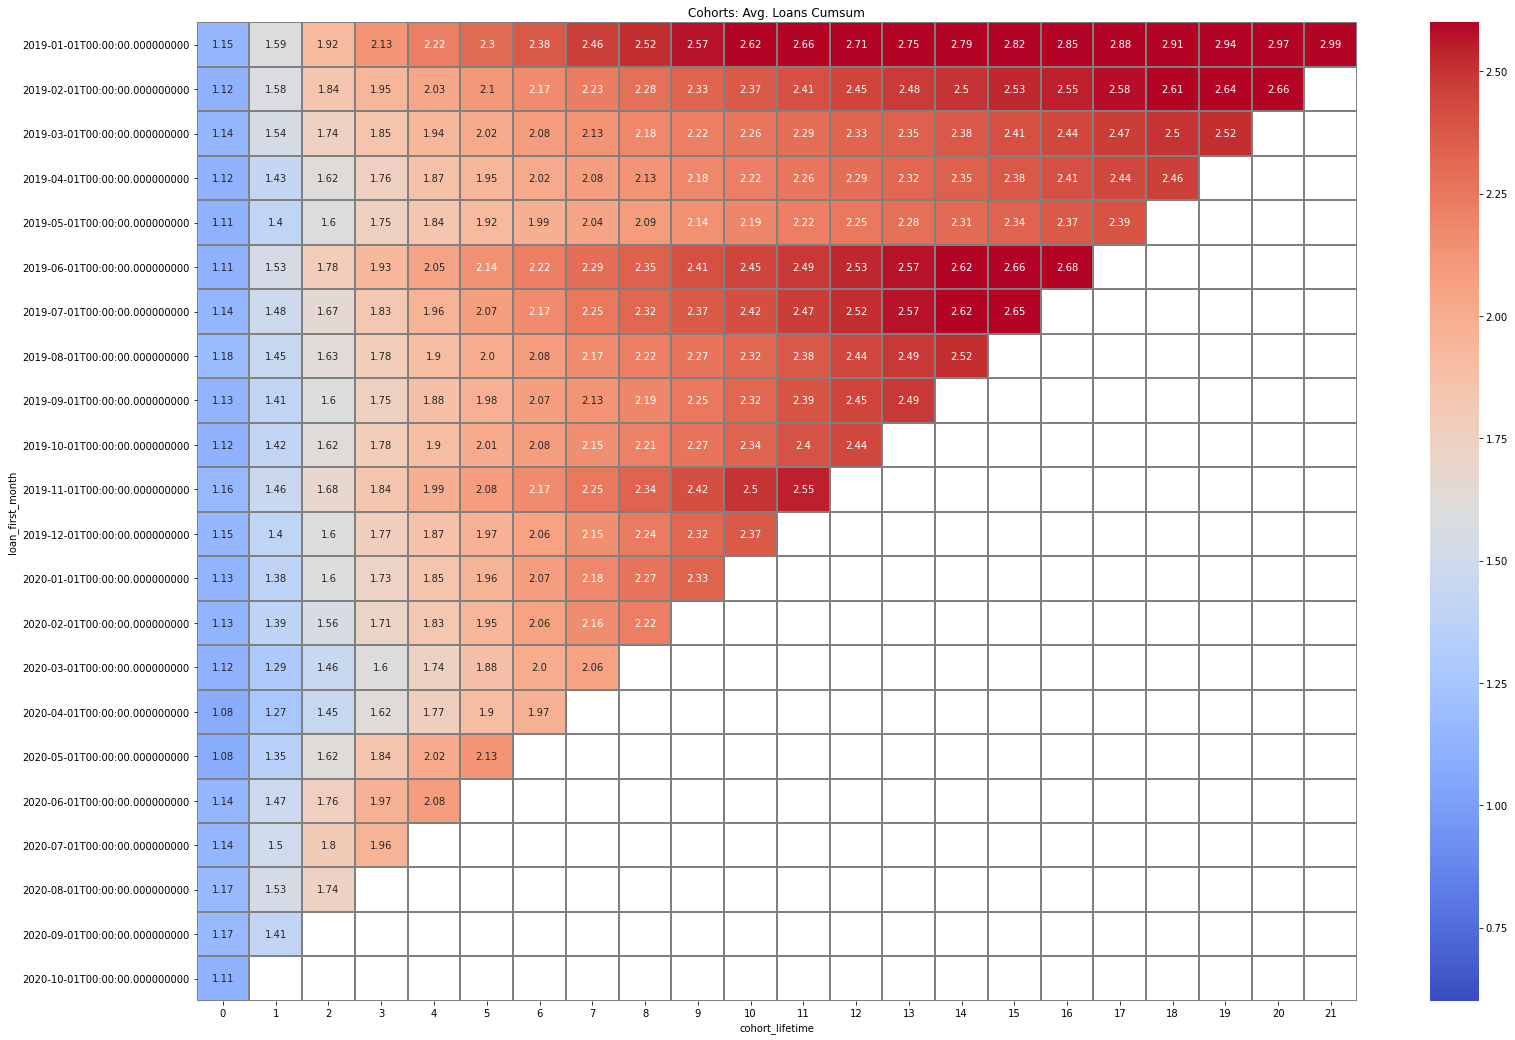

In [62]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Avg. Loans Cumsum')
sns.heatmap(avg_loan_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=0.6, vmax=2.6);

#### 5.3 ARPU (Average Revenue per User)
то, что Даша называет LTV

In [63]:
arpu = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum'}).reset_index()
arpu = pd.merge(arpu, initial_users, on='loan_first_month')
arpu['arpu'] = ((arpu['value'] / arpu['initial_users'])/1000).round(2)

arpu.head()

,loan_first_month,cohort_lifetime,value,initial_users,arpu
0,2019-01-01,0,73801900.0,7874,9.37
1,2019-01-01,1,34531000.0,7874,4.39
2,2019-01-01,2,27591800.0,7874,3.50
3,2019-01-01,3,20844600.0,7874,2.65
4,2019-01-01,4,10151955.2,7874,1.29


In [64]:
arpu_pivot = arpu.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='arpu', aggfunc='mean').cumsum(axis=1)

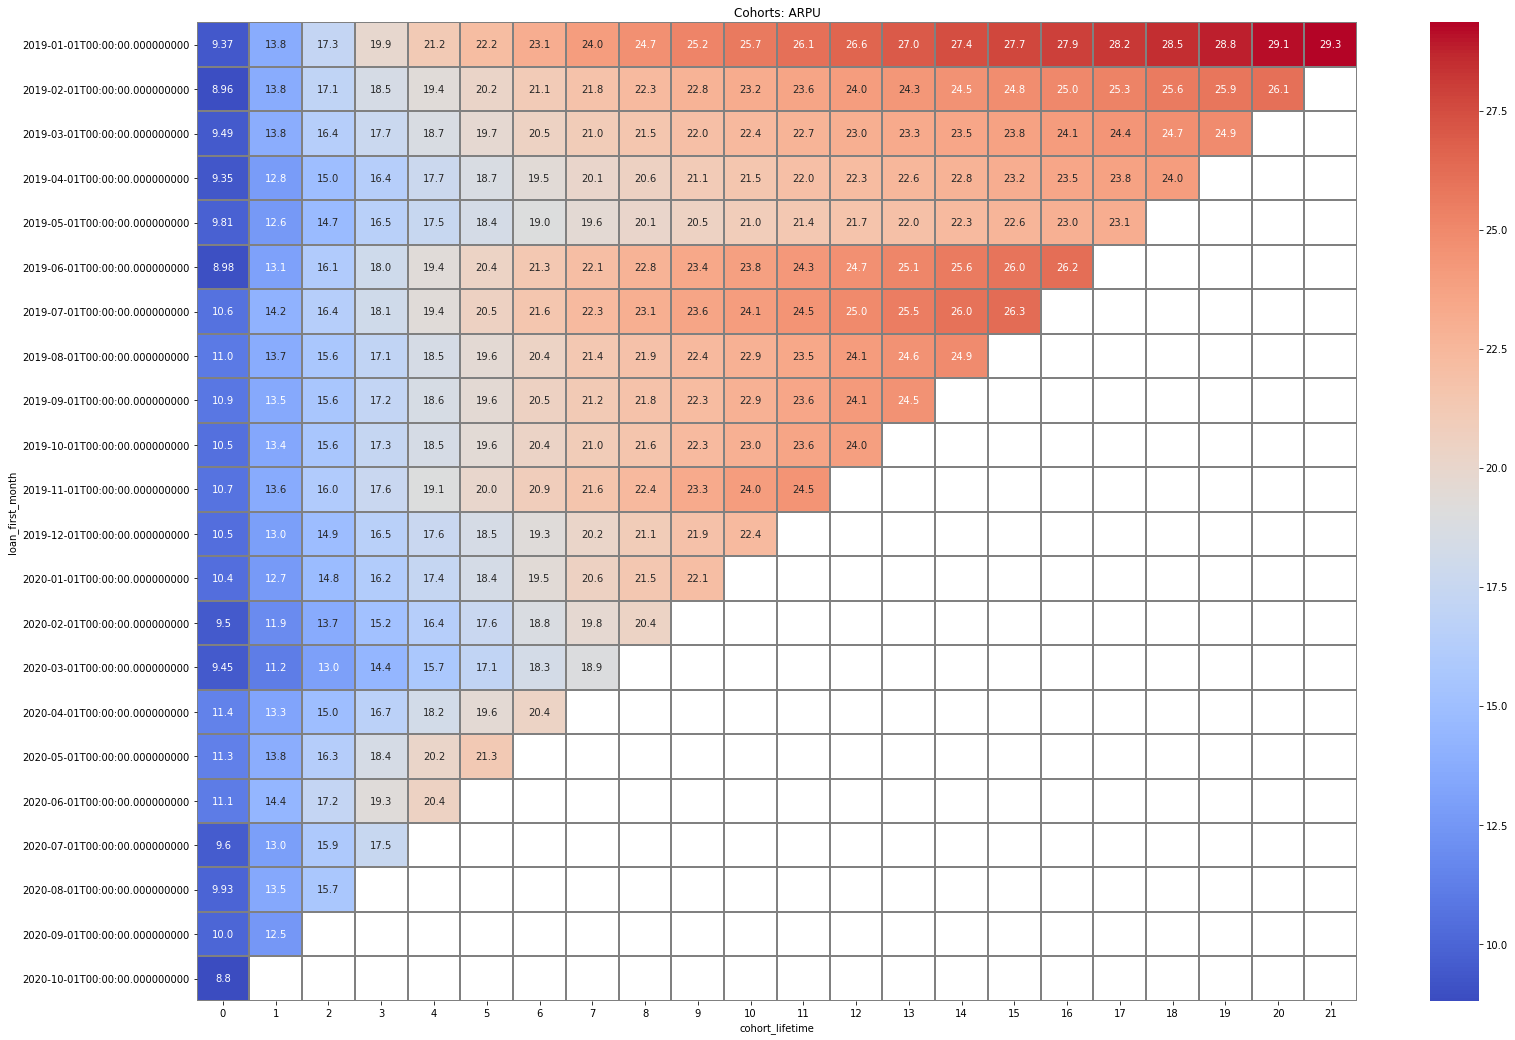

In [65]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: ARPU')
sns.heatmap(arpu_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm');

#### 5.4 Средняя сумма займа в конкретный месяц
почему с ростом lifetime "чек" не растет?

In [66]:
avg_loan_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', 'cid': 'count'}).reset_index()
avg_loan_value['avg_loan_value'] = ((avg_loan_value['value'] / avg_loan_value['cid'])/1000).round(2)

avg_loan_value.head()

,loan_first_month,cohort_lifetime,value,cid,avg_loan_value
0,2019-01-01,0,73801900.0,9051,8.15
1,2019-01-01,1,34531000.0,3447,10.02
2,2019-01-01,2,27591800.0,2628,10.50
3,2019-01-01,3,20844600.0,1623,12.84
4,2019-01-01,4,10151955.2,748,13.57


In [67]:
avg_loan_value_pivot = avg_loan_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='avg_loan_value', aggfunc='mean')

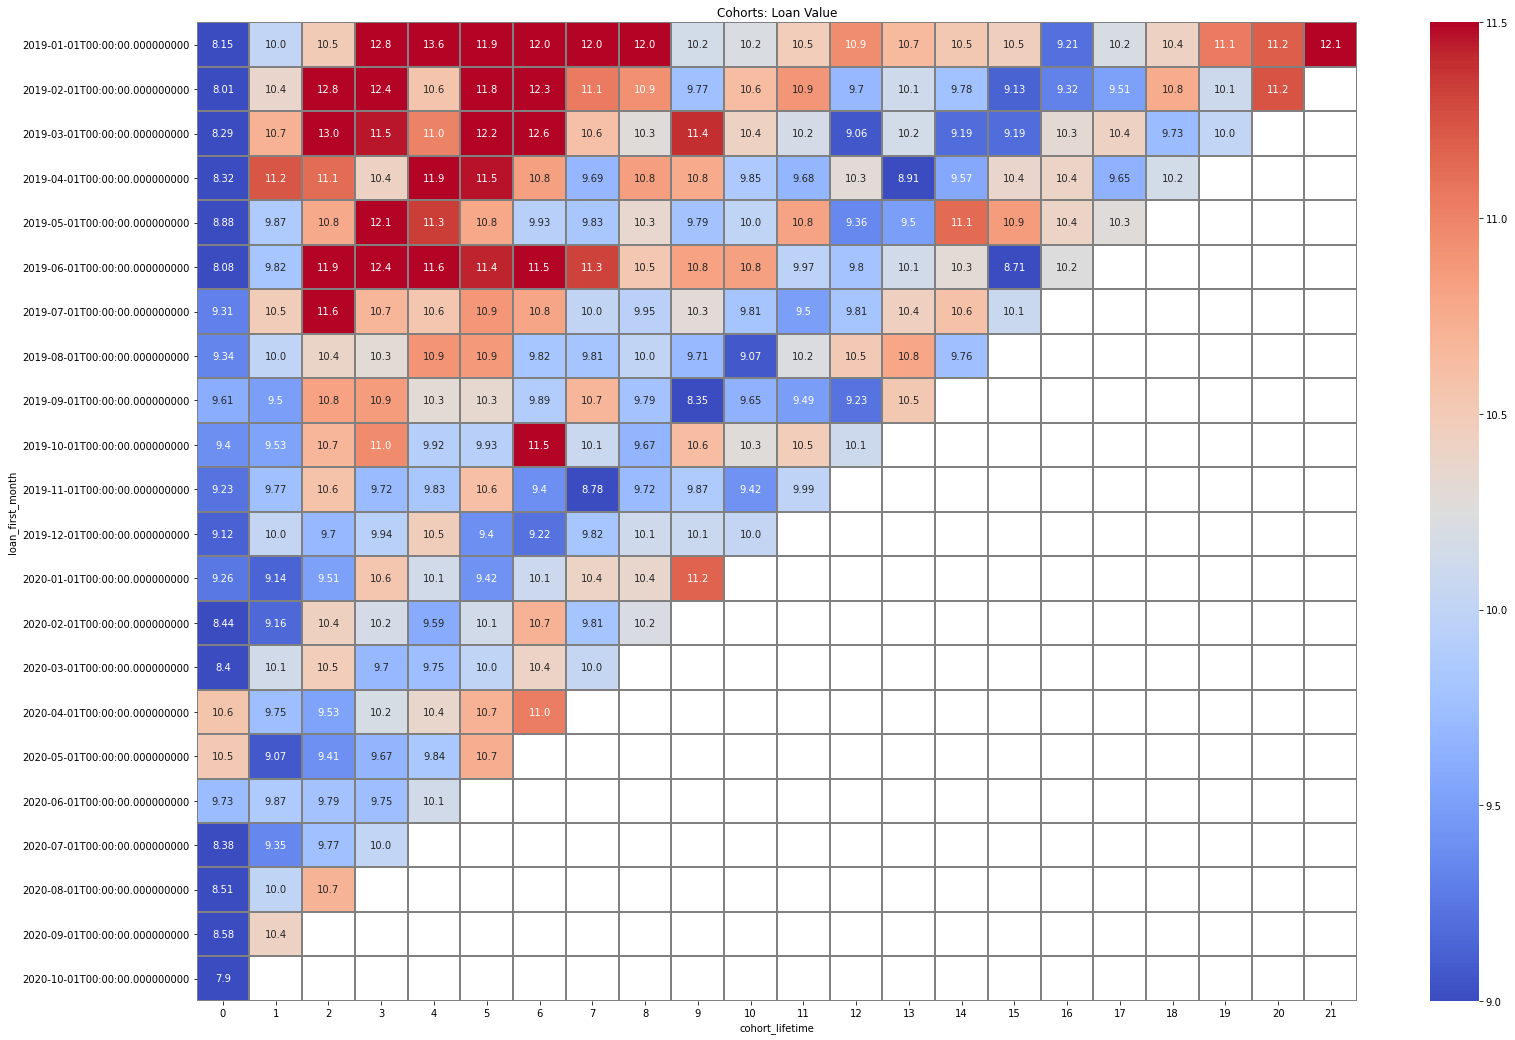

In [68]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Loan Value')
sns.heatmap(avg_loan_value_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=9, vmax=11.5);

#### 5.4 Средняя сумма займа накопительным итогом

In [69]:
avg_cumsum_loan_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', 'cid': 'count'})\
.groupby(level=0).cumsum().reset_index()
avg_cumsum_loan_value.rename(columns={'value': 'cumsum_value', 'cid': 'cumsum_loans'}, inplace=True)
avg_cumsum_loan_value['avg_cumsum_loan_value'] = ((avg_cumsum_loan_value['cumsum_value'] / avg_cumsum_loan_value['cumsum_loans'])/1000).round(2)

avg_cumsum_loan_value.head()

,loan_first_month,cohort_lifetime,cumsum_value,cumsum_loans,avg_cumsum_loan_value
0,2019-01-01,0,73801900.0,9051,8.15
1,2019-01-01,1,108332900.0,12498,8.67
2,2019-01-01,2,135924700.0,15126,8.99
3,2019-01-01,3,156769300.0,16749,9.36
4,2019-01-01,4,166921255.2,17497,9.54


In [70]:
avg_cumsum_loan_pivot = avg_cumsum_loan_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='avg_cumsum_loan_value', aggfunc='mean')

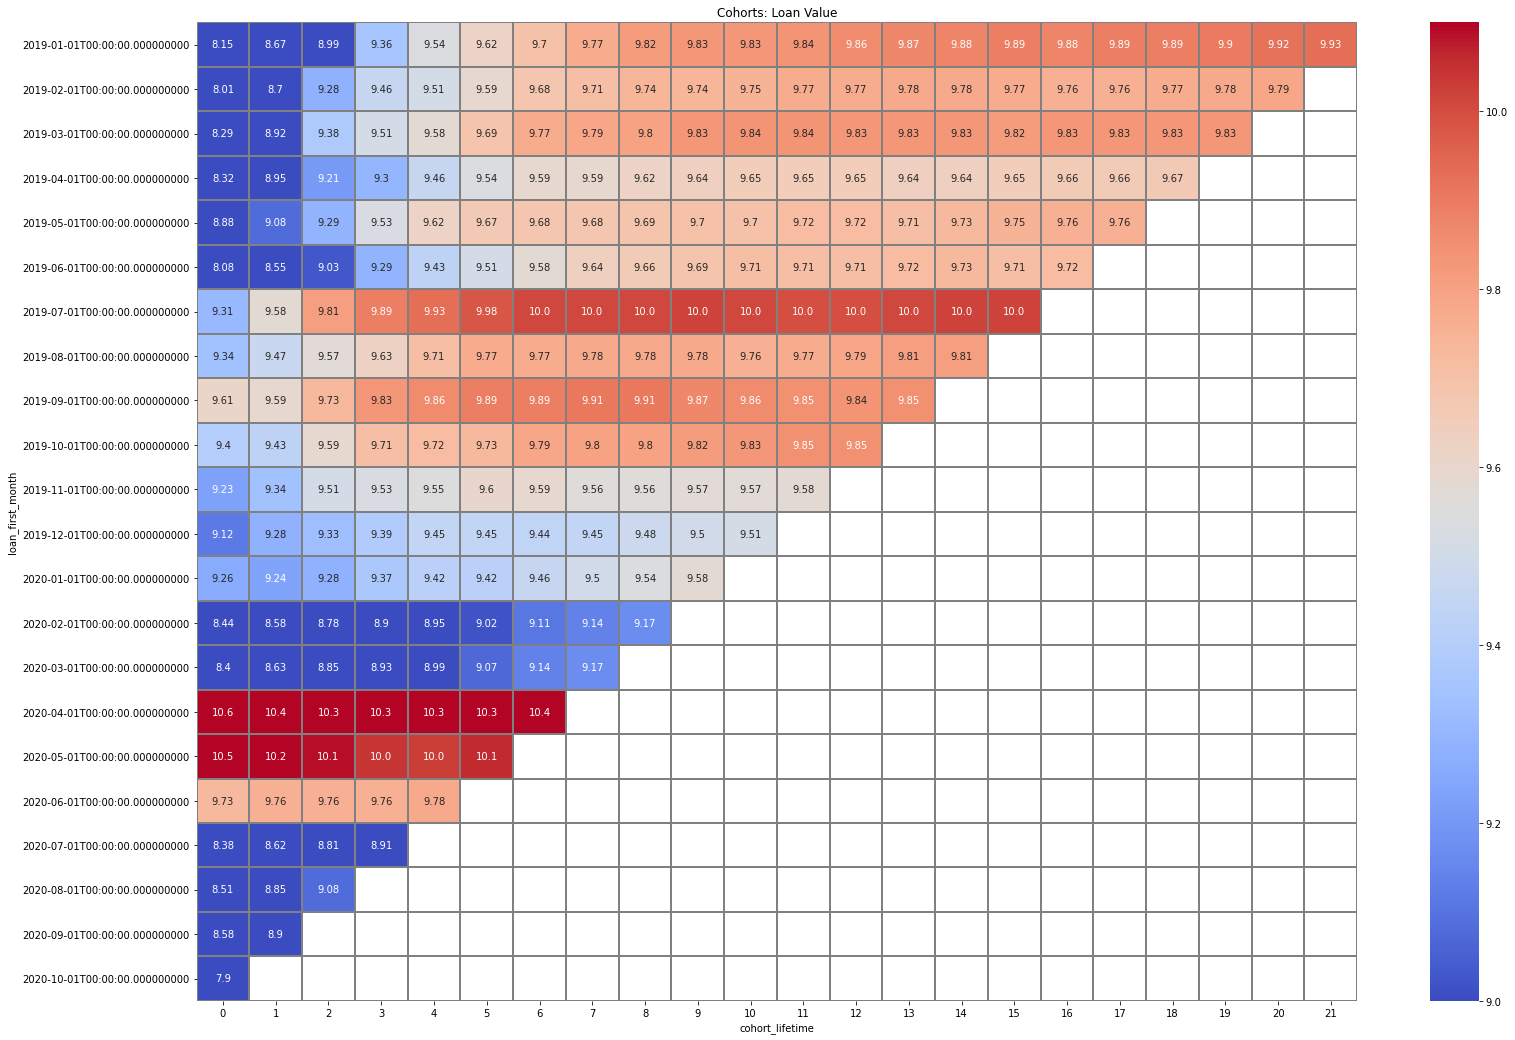

In [71]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Loan Value')
sns.heatmap(avg_cumsum_loan_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=9, vmax=10.1);

#### 5.5 Оборотка нарастающим итогом

In [72]:
cumsum_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', }).reset_index()
cumsum_value['value'] = (cumsum_value['value'] / 10000000).round(2)

cumsum_value

,loan_first_month,cohort_lifetime,value
0,2019-01-01,0,7.38
1,2019-01-01,1,3.45
2,2019-01-01,2,2.76
3,2019-01-01,3,2.08
4,2019-01-01,4,1.02
...,...,...,...
248,2020-08-01,1,3.12
249,2020-08-01,2,1.94
250,2020-09-01,0,8.50
251,2020-09-01,1,2.12


In [73]:
initial_value = cumsum_value[cumsum_value['cohort_lifetime'] == 0][['loan_first_month', 'value']]
initial_value.columns=['loan_first_month', 'initial_value']
initial_value

,loan_first_month,initial_value
0,2019-01-01,7.38
22,2019-02-01,7.86
43,2019-03-01,11.48
63,2019-04-01,12.35
82,2019-05-01,7.03
100,2019-06-01,4.42
117,2019-07-01,10.52
133,2019-08-01,9.31
148,2019-09-01,4.42
162,2019-10-01,6.31


In [74]:
cumsum_value = pd.merge(cumsum_value, initial_value, on='loan_first_month')
cumsum_value['value_gain'] = cumsum_value['value'] / cumsum_value['initial_value']

cumsum_value.head(20)

,loan_first_month,cohort_lifetime,value,initial_value,value_gain
0,2019-01-01,0,7.38,7.38,1.000000
1,2019-01-01,1,3.45,7.38,0.467480
2,2019-01-01,2,2.76,7.38,0.373984
3,2019-01-01,3,2.08,7.38,0.281843
4,2019-01-01,4,1.02,7.38,0.138211
5,2019-01-01,5,0.76,7.38,0.102981
6,2019-01-01,6,0.73,7.38,0.098916
7,2019-01-01,7,0.72,7.38,0.097561
8,2019-01-01,8,0.52,7.38,0.070461
9,2019-01-01,9,0.42,7.38,0.056911


In [75]:
cumsum_value_pivot = cumsum_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                         values='value_gain', aggfunc='mean').cumsum(axis=1)

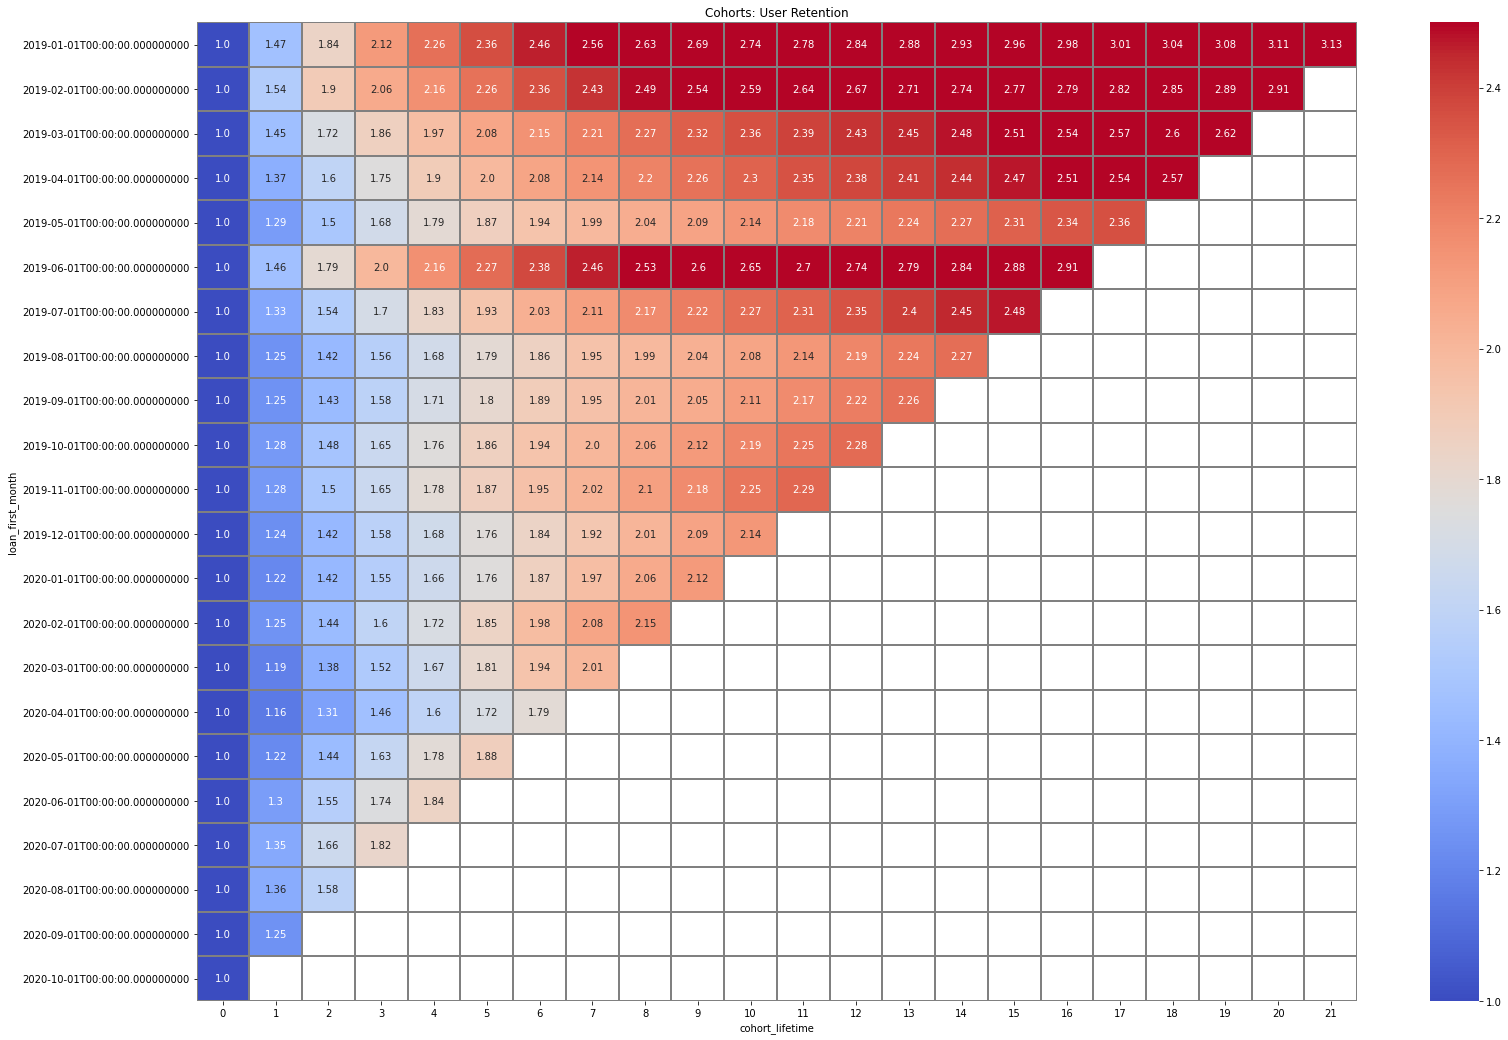

In [76]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: User Retention')
sns.heatmap(cumsum_value_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmax=2.5);

In [77]:
loans['end_month'] = loans['end_ts'].astype('datetime64[M]')
loans.head()

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month,real_term,term_category,loan_first_month,cohort_lifetime,end_month
0,2825209,2019-01-01,9900.0,30,Погашен,2019-01-10,2019-01-01,2018-12-31,2019-01-01,9.0,Досрочно,2019-01-01,0,2019-01-01
1,2825209,2019-01-14,10000.0,30,Погашен,2019-01-18,2019-01-14,2019-01-14,2019-01-01,4.0,Досрочно,2019-01-01,0,2019-01-01
2,2825209,2019-01-25,10000.0,23,Погашен,2019-01-25,2019-01-25,2019-01-21,2019-01-01,0.0,Досрочно,2019-01-01,0,2019-01-01
3,2825209,2019-01-30,10000.0,16,Погашен,2019-02-11,2019-01-30,2019-01-28,2019-01-01,12.0,Досрочно,2019-01-01,0,2019-02-01
4,2825209,2019-02-24,10000.0,16,Погашен,2019-03-12,2019-02-24,2019-02-18,2019-02-01,16.0,В срок,2019-01-01,1,2019-03-01


In [78]:
get_loans = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'count'}).groupby(level=0).cumsum().reset_index()
get_loans.rename(columns={'cid': 'get_loans'}, inplace=True)
get_loans.head()

,loan_first_month,cohort_lifetime,get_loans
0,2019-01-01,0,9051
1,2019-01-01,1,12498
2,2019-01-01,2,15126
3,2019-01-01,3,16749
4,2019-01-01,4,17497


In [79]:
paid_loans = loans.groupby(['loan_first_month', 'end_month']).agg({'cid': 'count'}).groupby(level=0).cumsum().reset_index()
paid_loans['cohort_lifetime'] = ((paid_loans['end_month'] - paid_loans['loan_first_month']) / np.timedelta64(1,'M')).round().astype('int')
paid_loans.drop(columns='end_month', inplace=True)
paid_loans = paid_loans[['loan_first_month', 'cohort_lifetime', 'cid']]
paid_loans.rename(columns={'cid': 'paid_loans'}, inplace=True)

paid_loans.head()

,loan_first_month,cohort_lifetime,paid_loans
0,2019-01-01,0,2447
1,2019-01-01,1,7365
2,2019-01-01,2,9839
3,2019-01-01,3,11440
4,2019-01-01,4,12344


In [80]:
output = pd.merge(get_loans, paid_loans, on=['loan_first_month', 'cohort_lifetime'])
output['r_rate'] = output['paid_loans'] / output['get_loans']
output_pivot = output.pivot_table(index='loan_first_month', columns='cohort_lifetime', values='r_rate')

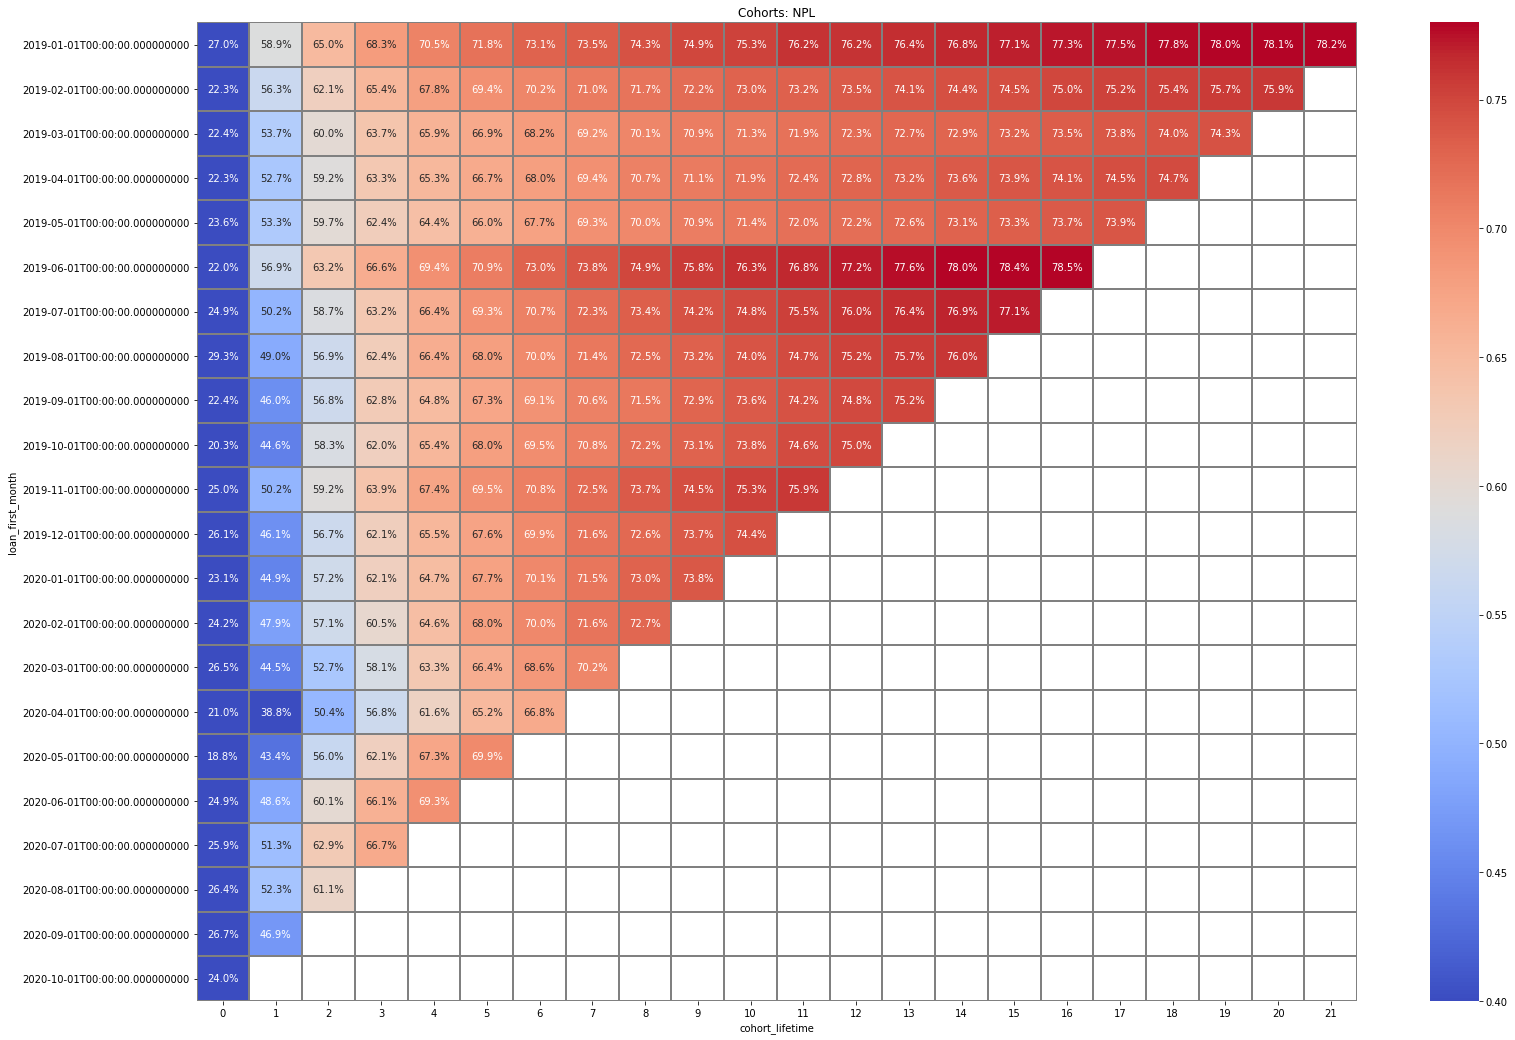

In [81]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: NPL')
sns.heatmap(output_pivot, annot=True, fmt='.1%', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=0.4, vmax=0.78);